In [1]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

# required imports 
import numpy as np
import pandas as pd
import networkx as nx
import scraper
import matplotlib.pyplot as plt
import powerlaw
import scipy.stats as sps
from itertools import chain

## Disclaimer

Many of the processing steps in this notebook are memory-intensive. Running the entire notebook in one go may not be possible, depending on the amount of ram your computer has, and will take several minutes.

## Codebase

Since our codebase is too large for a single notebook, we decided to upload it elsewhere. Details of our implementation, especially the rather complex scraper and classifier, and all the files required for execution of this notebook can be found on GitHub: https://github.com/andste97/socialgraphs2023f-project

## Data cleaning, creating the network
We begin by fetching the first 3 levels of the `Wikipedia vital articles` category using our own `scraper`. The resulting initial graph is also saved for later use. We used the `page_class` node attribute to separate the classes of `user` and `article`. Nodes $a$ and $b$ from the `article` class were connected by edge $a \rightarrow b$ if the content of the Wikipedia article corresponding to $a$ contained a link to article $b$. Similarly, directed edges $u \rightarrow a$ were added between article $a$ and all user nodes $u$ found by parsing the corresponding talk page.

In [2]:
category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
]

In [3]:
# download data
page_graph, infos  = await scraper.scrape_wiki(category_titles)
# write created graph to disk so it does not need to be re-fetched and re-computed so often
nx.write_graphml(page_graph, "wikigraph.graphml")

Fetching 1000 revisions: 100%|██████████| 1000/1000 [01:53<00:00,  8.27s/it]

Creating graph


Linking articles: 100%|██████████| 1000/1000 [00:00<00:00, 2293.53it/s]


Total edges: 228198


Fetching 1000 revisions: 100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


Next we remove bot users. Our list of bot user names was compiled by filtering nodes of type `user` containing the substring `bot`. Since Wikipedia doesn't have an official bot name convention we verified the resulting user list manually. We then compute basic network properties on the remaining graph.

In [2]:
# read saved initial graph
graph = nx.read_graphml("wikigraph.graphml")

# remove bot users from graph
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)

# Print network properties
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(graph)}")
print(f"Number of weakly connected components: {len(list(nx.weakly_connected_components(graph)))}")
degrees_dict = {"Node": dict(graph.degree).keys(), "Total Degree": dict(graph.degree).values(), "In Degree": dict(graph.in_degree).values(), "Out Degree": dict(graph.out_degree).values()}
degrees_view = pd.DataFrame(degrees_dict).set_index("Node")
print("Top 5 nodes with largest in-degree:")
degrees_view.sort_values(["Total Degree"], ascending=False).head(5)

Number of nodes: 80580
Number of edges: 176368
Average clustering coefficient: 0.04063680702604195
Number of weakly connected components: 1
Top 5 nodes with largest in-degree:


,Total Degree,In Degree,Out Degree
Node,,,
United States,2458,2276,182
Jesus,1942,1903,39
India,1835,1652,183
Climate change,1800,1777,23
Israel,1696,1636,60


In [4]:
graph_u = graph.to_undirected()

# filter for user names and article titles in the graph
nodes_by_class = dict(graph.nodes(data="page_class"))
user_names = [node for node in nodes_by_class if nodes_by_class[node] == "user"]
article_titles = [node for node in nodes_by_class if nodes_by_class[node] == "article"]

users_graph = graph.subgraph(user_names)
articles_graph = graph.subgraph(article_titles)
print(f"Number of article pages: {articles_graph.number_of_nodes()}")
print(f"Connections between article pages: {articles_graph.number_of_edges()}")
print(f"Connections between user pages: {users_graph.number_of_edges()}")

# returns true if the edge with endpoints u and v is between an article and a user node
def isDifferentClass(graph, u, v):
    ua = graph.nodes[u]["page_class"] == "user" and graph.nodes[v]["page_class"] == "article"
    au = graph.nodes[u]["page_class"] == "article" and graph.nodes[v]["page_class"] == "user"
    return ua or au

print(f"Connections between users and articles: {len([(u,v) for (u, v) in graph_u.edges() if isDifferentClass(graph_u, u, v)])}")

Number of article pages: 1000
Connections between article pages: 17311
Connections between user pages: 0
Connections between users and articles: 159057


Below we plot the total degree distribuiton on a log-log scale. As we can see, our network is not scale-free but an inherent imbalance can be clearly seen. Additionally, the clustering of high-degree nodes skews the power-law fit. The number of edges between articles is much smaller than the number of edges between users and articles. This means that the differences in degrees are for the most part caused by the edges corresponding to user edits. Therefore we conclude that a a minority of the articles are edited by a majority of the users.

Exponents:ess: 97%
Alpha: 1.5138043908061927 sigma: 0.07928173872662739


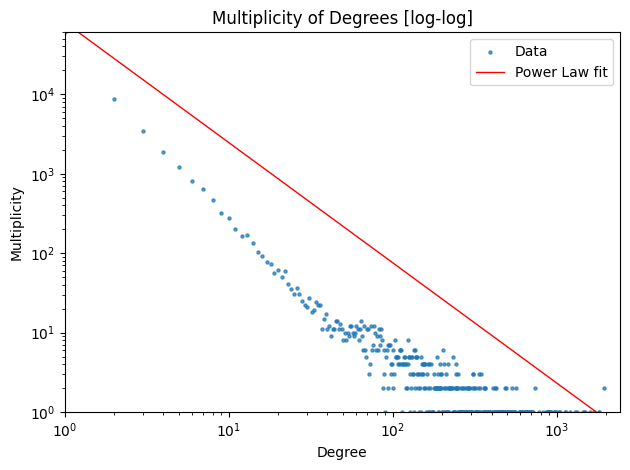

In [16]:
# Plotting degree distributions


def largest_weakly_connected_c(graph):
     # extract largest weakly connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def fpl(x, a):
    return x ** (-a)

def render_degree_distributions_single(biggest_comp, colors, isDirected = True):
    count_nodes = biggest_comp.number_of_nodes()
    count_edges = biggest_comp.number_of_edges()

    # Random Graph
    avg_degree = np.fromiter(dict(biggest_comp.degree).values(), dtype=int).mean()
    er_graph = nx.erdos_renyi_graph(count_nodes, avg_degree/(count_nodes - 1))
    er_degrees = np.fromiter(dict(er_graph.degree).values(), dtype=int)
    hist_er = np.histogram(er_degrees, bins=np.sort(np.unique(er_degrees)))

    max_degree = max(dict(biggest_comp.degree).values())
    range_x = range(1, max_degree + 1)

    degrees = np.fromiter(dict(biggest_comp.degree).values(), dtype=int)
    hist = np.histogram(degrees, bins=np.sort(np.unique(degrees)))

    max_multiplicity = max(hist[0])

    # Exponent
    fit_exp = powerlaw.Fit(hist[0], verbose=False)
    exp = fit_exp.alpha

    print("Exponents:")
    print("Alpha: " + str(exp) + " sigma: " + str(fit_exp.sigma))
    rows = 1
    data_dicts = [hist]
    dists = [fpl(range_x, exp)]
    titles = ["Multiplicity of Degrees"]
    # Plots
    fig, axs = plt.subplots(rows, 1)

    for y, (hist, dist, title, color) in enumerate(zip(data_dicts, dists, titles, colors)):
        counts, bins = hist
        
        axs.scatter(bins[:-1], counts, s=5, label="Data", alpha=0.7)
        axs.plot(range_x, dist * count_nodes, "k-", lw=1, label="Power Law fit", color='red')
        axs.set_yscale("log")
        axs.set_xscale("log")
        axs.set_title(f"{title} [log-log]")

        #for x in range(2):
        axs.set_xlim(1, max_degree)
        axs.set_ylim(1, max_multiplicity)
        axs.legend()

    axs.set(xlabel="Degree", ylabel="Multiplicity")

    fig.tight_layout()
    return fig, axs

colors = ["cornflowerblue", "red", "green"]
render_degree_distributions_single(largest_weakly_connected_c(graph).to_undirected(), colors)
plt.show()

## Analysis of the articles subgraph

First we analyse the subgraph constructed by only taking the article nodes from our initial graph and the edges between them. We investigate number of nodes, edges, average clustering coefficient and top 5 nodes by in and out degree.

In [5]:
article_references = pd.DataFrame(articles_graph.in_degree, columns=["Node", "In Degree"]).set_index("Node")
article_references["Out Degree"] = pd.Series(dict(articles_graph.out_degree).values(), index=dict(articles_graph.out_degree).keys())
article_references["Total Degree"] = pd.Series(dict(articles_graph.degree).values(), index=dict(articles_graph.degree).keys())
print("Properties of the articles subgraph:")
print(f"Number of nodes: {articles_graph.number_of_nodes()}")
print(f"Number of edges: {articles_graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(articles_graph)}")
print("Top 5 articles by in-degree:")
print(article_references.sort_values("In Degree", ascending=False).head(5))
print("Top 5 articles by out-degree:")
print(article_references.sort_values("Out Degree", ascending=False).head(5))

Properties of the articles subgraph:
Number of nodes: 1000
Number of edges: 17311
Average clustering coefficient: 0.14285079028156
Top 5 articles by in-degree:
                   In Degree  Out Degree  Total Degree
Node                                                  
Human history            130           5           135
Human                    103          15           118
Europe                   101         128           229
History of Europe         87           4            91
Asia                      85          71           156
Top 5 articles by out-degree:
               In Degree  Out Degree  Total Degree
Node                                              
World War II          27         210           237
Latin                 19         209           228
India                 51         183           234
United States         55         182           237
Aristotle             35         171           206


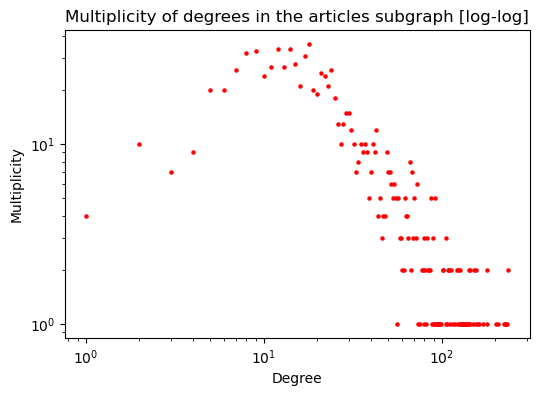

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
degree_counts = article_references["Total Degree"].value_counts()
ax.scatter(degree_counts.index, degree_counts.values, s=5, label='Data', color="red")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set(xlabel="Degree", ylabel="Multiplicity")
ax.set_title('Multiplicity of degrees in the articles subgraph [log-log]')
plt.show()

As we can see the articles subgraph is not scale-free. Next we perform community detection using the `louvain_community_detection` function which implements the [Louvain algorithm](https://sites.google.com/site/findcommunities/).

In [107]:
def louvain_community_detection(graph):
    graph_no_isolated = graph.copy()
    graph_no_isolated.remove_nodes_from([node for node in graph.nodes if graph.degree(node) < 1])
    louvain_partition_raw = nx.community.louvain_communities(graph_no_isolated)
    print("Number of communities found: ", len(louvain_partition_raw))
    print("Modularity of louvain partitions: ", nx.community.modularity(graph_no_isolated, louvain_partition_raw))
    return louvain_partition_raw

In [153]:
louvain_partition = louvain_community_detection(articles_graph)

Number of communities found:  21
Modularity of louvain partitions:  0.2943964685825948


In [154]:
def plot_community_sizes(partition, ax, title):
    sorted_size_communities = sorted([len(comm) for comm in partition])
    ax.bar([x for x in range(1,len(partition)+1)], sorted_size_communities, color="cornflowerblue")
    ax.set_title(label=title)
    ax.set_xlabel(xlabel="Index of communities")
    ax.set_ylabel(ylabel="Number of nodes")
    ax.set_xticks([x for x in range (1,len(partition)+1)])
    max_c = sorted_size_communities[-1]
    ax.set_ylim((0, max_c + 40))

    rects = ax.patches
    labels = [size for size in sorted_size_communities]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")

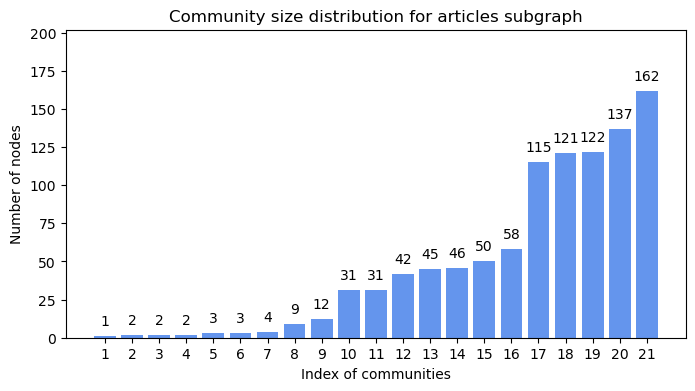

In [155]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_community_sizes(louvain_partition, ax, "Community size distribution for articles subgraph")  
plt.show()

Throughout multiple runs, the algorithm detected from 15 to 20 communities with a modularity between 0.28 and 0.31 each time. The above figure shows the size distribution of the communities found during our last run of the algorithm. The low modularity and the excessively small or large communities could be a result of the wikipedia article subset, as the vital articles category aims to provide an overview with a diverse set of important topics.

## Shared user groups between article pairs

We create a graph where the nodes are the articles and two nodes are connected by an edge of weight $w$ if exactly $w$ users contributed to both. Groups of shared articles are constructed using function `add_weighted_edges` by evaluating each article nodes' neighbourhoud in the source graph. The weighted edges corresponding to the shared editor groups is then added.

In [6]:
def add_weighted_edges(graph, source, node_type, frontier_type, frontier_key):
    for node in list(graph.nodes):
        related = {}
        # get neighbouring nodes of the opposite type
        frontier = set(n for n in source.neighbors(node) if source.nodes[n]["page_class"] == frontier_type)
        graph.nodes[node][frontier_key] = len(frontier)
        for f in frontier:
            neighbor_nodes = list( n for n in source.neighbors(f) if source.nodes[n]["page_class"] == node_type)
            for n in neighbor_nodes:
                if n != node:
                    if n in related:
                        related[n] += 1
                    else:
                        related[n] = 1
        graph.add_weighted_edges_from([(node, r, related[r]) for r in related])

In [7]:
common_editors = nx.Graph()
common_editors.add_nodes_from(article_titles)
add_weighted_edges(common_editors, graph_u, "article", "user", "editors_no")

We then perform analysis on the  resulting undirected weighted graph. As we can see, there has been a slight reordering in the top 5 articles by editor number. This is probably due to users that only contributed to one article being filtered out during construction of the graph and due to the lack of inter-article connections based on content links.

In [8]:
print(f"Number of nodes: {common_editors.number_of_nodes()}")
print(f"Number of edges: {common_editors.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(common_editors)}")
print(f"Average clustering coefficient: {nx.average_clustering(common_editors)}")
edge_weight_dict = nx.get_edge_attributes(common_editors, "weight")
editors_dict = common_editors.nodes(data="editors_no")
editors_view = pd.DataFrame(editors_dict, columns=["Node", "Editors"]).set_index("Node")
print(f"Maximum editors: {editors_view.Editors.max()}")
print(f"Average editors: {editors_view.Editors.mean()}")
print(f"Median editors: {editors_view.Editors.median()}")

print("\nTop 5 nodes by overall number of editors:")
editors_view.sort_values(["Editors"], ascending=False).head(5)


Number of nodes: 1000
Number of edges: 242107
Number of connected components: 3
Average clustering coefficient: 0.708347877885475
Maximum editors: 2221
Average editors: 159.057
Median editors: 86.0

Top 5 nodes by overall number of editors:


,Editors
Node,
United States,2221
Jesus,1879
Climate change,1768
Israel,1612
India,1601


In [18]:
degree_a = [editors_dict[edge[0]] for edge in edge_weight_dict.keys()]
degree_b = [editors_dict[edge[1]] for edge in edge_weight_dict.keys()]
edges = [f"{u}, {v}" for (u, v) in edge_weight_dict.keys()]
shared_user_df = pd.DataFrame({"Edge": edges, "Weight": edge_weight_dict.values(), "Editors A": degree_a,
                              "Editors B": degree_b}).set_index("Edge")
print(f"Maximum edge weight: {shared_user_df.Weight.max()}")
print(f"Average edge weight: {shared_user_df.Weight.mean()}")
print(f"Median edge weight: {shared_user_df.Weight.median()}")
print("\nTop 10 node pairs by overall number of shared editors:")
most_raw_connected = shared_user_df.sort_values(["Weight"], ascending=False).head(10)
most_raw_connected

Maximum edge weight: 221
Average edge weight: 3.3285695993920044
Median edge weight: 2.0

Top 10 node pairs by overall number of shared editors:


,Weight,Editors A,Editors B
Edge,,,
"Christianity, Jesus",221,985,1879
"Israel, Jerusalem",206,1612,637
"Islam, Muhammad",203,1127,1396
"Jesus, United States",178,1879,2221
"Jesus, Muhammad",176,1879,1396
"China, Taiwan",174,842,937
"Adolf Hitler, Jesus",168,1535,1879
"United Kingdom, United States",163,1188,2221
"Israel, United States",147,1612,2221


Above we see metrics of the weights assigned to edges as the top 10 article pairs by shared editor count. While there are a few surprising connections (e.g. Adolf Hitler and Jesus), most of the node pairs we see here are semantically related. We also note that these topics also have a high editor count individually which contributes to them being part of the top 10.

Now we will investigate what percentage of their editors different articles share with others. We will construct a directed graph this time, and compute a relative for edge $a \rightarrow b$ in the following way:
$$w_{rel} = \frac{w}{editors(a)} \cdot 100$$
where $w$ is the number of shared editors between $a$ and $b$ and $editors(a)$ is the corresponding number of editors for article $a$. We can compute the relative weights for all edges directly using `shared_user_df`. The 100 multiplier was added to give a percentage view of the results.

In [30]:
shared_user_df["Relative Weight (%)"] = shared_user_df.Weight / shared_user_df["Editors A"] * 100
desc_rel_weight = shared_user_df.sort_values(["Relative Weight (%)"], ascending=False)
print(f"Max edge weight: {shared_user_df['Relative Weight (%)'].max()}")
print(f"Average edge weight: {shared_user_df['Relative Weight (%)'].mean()}")
print(f"Median edge weight: {shared_user_df['Relative Weight (%)'].median()}")
print("\nTop 10 node pairs by ratio of shared editors:")
desc_rel_weight[(desc_rel_weight["Editors A"] > 20) & (desc_rel_weight["Editors B"] > 20)].head(10)

Max edge weight: 100.0
Average edge weight: 2.2928565414885926
Median edge weight: 1.5965939329430547

Top 10 node pairs by ratio of shared editors:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"History of India, India",83,205,1601,40.487805
"Delhi, India",72,181,1601,39.779006
"Post-classical history, United States",11,28,2221,39.285714
"Nth root, Pi",12,31,587,38.709677
"Visual arts, Art",12,32,165,37.500000
"Post-classical history, Middle Ages",10,28,206,35.714286
"Deity, God",18,51,642,35.294118
"Climate, Climate change",14,40,1768,35.000000
"Bhagavad Gita, Hinduism",44,126,554,34.920635


As we can see, the article pairs ranked higher by relative weight have a stronger semantic connection. The maximal relative weight for an edge is 1.0. This is because some articles have only one editor in our subset and as soon as they edit another article, the edge with weight 1.0 is created. To avoid overrepresenting these types of connections we chose to only evaluate connections of the articles with at least 20 editors. 

As we can see above, the relative weight metric uncovers strong connections between more niche topics as well (e.g between Mahayana and Theravada Buddhism). Now let's see the shared user percentages for the highest ranking edges by overall number of editors.

In [27]:
top_by_count = shared_user_df.loc[most_raw_connected.index]
no_higher = len(shared_user_df.loc[shared_user_df['Relative Weight (%)'] > top_by_count['Relative Weight (%)'].max()])
all_above_min = len(shared_user_df.loc[shared_user_df['Relative Weight (%)'] >= top_by_count['Relative Weight (%)'].min()])
print(f"Number of edges with higher weights: {no_higher}")
print(f"Below edges are in the top {all_above_min / len(shared_user_df) * 100:.2}%")
print("\nRelative shared editors for the top 10 edges by shared editor number:")
top_by_count

Number of edges with higher weights: 312
Below edges are in the top 2.1%

Relative shared editors for the top 10 edges by shared editor number:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"Christianity, Jesus",221,985,1879,22.436548
"Israel, Jerusalem",206,1612,637,12.779156
"Islam, Muhammad",203,1127,1396,18.012422
"Jesus, United States",178,1879,2221,9.473124
"Jesus, Muhammad",176,1879,1396,9.366684
"China, Taiwan",174,842,937,20.665083
"Adolf Hitler, Jesus",168,1535,1879,10.944625
"United Kingdom, United States",163,1188,2221,13.720539
"Israel, United States",147,1612,2221,9.119107


This shows that the most edited articles are still ranked very high overall. Now let's see the 10 lowest rankied topics.

In [43]:
print("Bottom 10 node pairs by percentage of shared editors:")
asc_rel_weight = shared_user_df.sort_values(["Relative Weight (%)"], ascending=True)
asc_rel_weight.head(10)

Bottom 10 node pairs by percentage of shared editors:


,Weight,Editors A,Editors B,Relative Weight (%)
Edge,,,,
"United States, Weapon",1,2221,26,0.045025
"United States, Wave",1,2221,46,0.045025
"Jesus, Word",1,1879,24,0.053220
"Jesus, Suffrage",1,1879,21,0.053220
"Jesus, Navigation",1,1879,20,0.053220
"Jesus, Lipid",1,1879,31,0.053220
"Jesus, Motion",1,1879,28,0.053220
"Jesus, Rocky Mountains",1,1879,43,0.053220
"Jesus, Realism (arts)",1,1879,9,0.053220


In [51]:
print("United States article contains link to Weapon: ", "United States" in list(articles_graph.neighbors("Weapon")))
print("Weapon article contains link to United States: ", "Weapon" in list(articles_graph.neighbors("United States")))

United States article contains link to Weapon:  True
Weapon article contains link to United States:  True


The low weight of the edge between the United States and Weapon articles is surprising especially because both of these articles link to each other in their page content. 

Most of the other results make sense as the article titles are not semantically related to each other.

Overall by focusing on user collaboration, we see a different article network structure emerging to the one constructed through page content links. Let us investigate this through community detection using the [Louvain algorithm](https://sites.google.com/site/findcommunities/).

In [110]:
common_editors_rel = nx.Graph()
common_editors_rel.add_nodes_from(article_titles)

s = shared_user_df["Relative Weight (%)"]
edge_endpoints = np.array([edge_str.split(", ") for edge_str in s.index])
rel_weighted_edges = list(zip(edge_endpoints[:,0], edge_endpoints[:,1], s))
common_editors_rel.add_weighted_edges_from(rel_weighted_edges)

print(f"Number of nodes: {common_editors_rel.number_of_nodes()}")
print(f"Number of edges: {common_editors_rel.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(common_editors_rel)}")

Number of nodes: 1000
Number of edges: 242107
Average clustering coefficient: 0.708347877885475


In [191]:
print("Weights are raw shared editor numbers:")
louvain_partition_raw = louvain_community_detection(common_editors)

print("---------------------------------")

print("Weights are relative shared editor numbers:")
louvain_partition_rel = louvain_community_detection(common_editors_rel)

Weights are raw shared editor numbers:
Number of communities found:  6
Modularity of louvain partitions:  0.14304896102858722
---------------------------------
Weights are relative shared editor numbers:
Number of communities found:  5
Modularity of louvain partitions:  0.14547546653848578


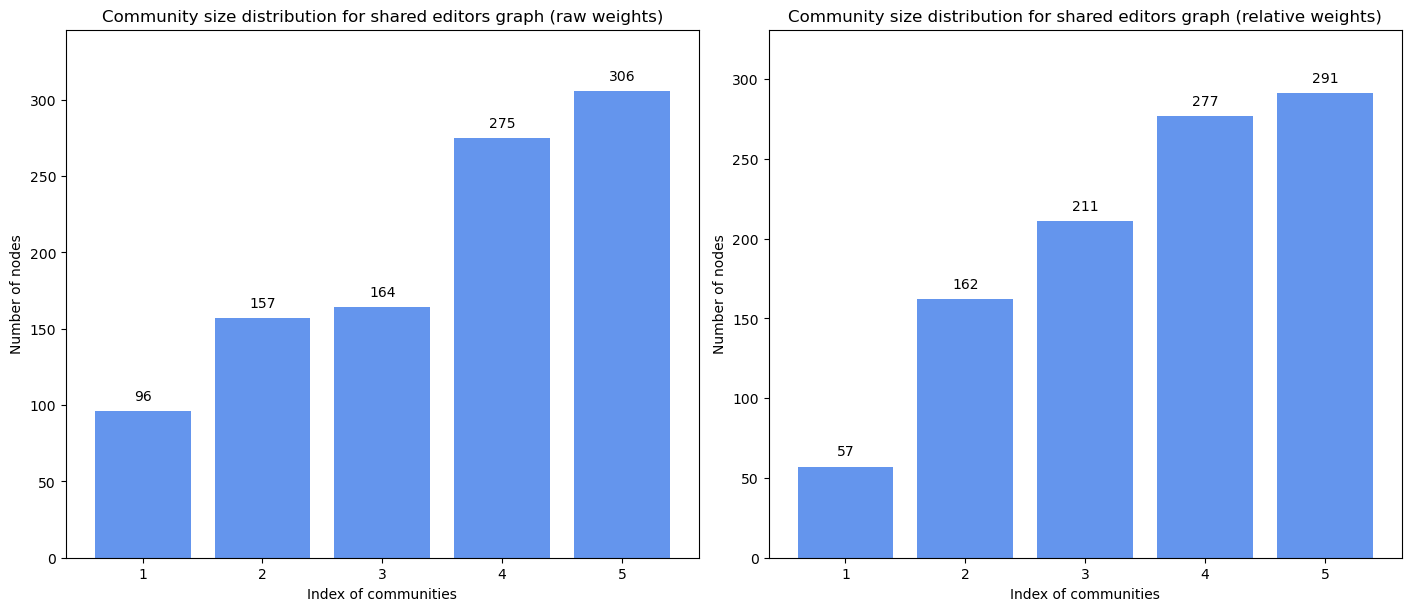

In [189]:
titles = ["Community size distribution for shared editors graph (raw weights)", "Community size distribution for shared editors graph (relative weights)"]
partitions = [louvain_partition_raw, louvain_partition_rel]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), layout="constrained")
for idx, (title, partition) in enumerate(zip(titles, partitions)):
    plot_community_sizes(partition, ax[idx], title)
plt.show()


These results suggest that user preferences usually do not align to the groupings based on article topics. While we see users with specific expertise mainly contributing to a small niche of articles; the more popular ond/or controversial topics have a major appeal to all users. 
This difference in connectedness is also reflected by the difference in the average clustering coefficient of the graphs. Two arbirarily chosen nodes are much more likely to have an edge between them in the shared editors graph than the article subgraph.

The Louvain algorithm identified fewer communities in the shared editors graph than for the articles subgraph. This further emphasises the differences in strucure between the two, even though neither partition had a high modularity. 

These differences may contribute to diverse discussions on article talk pages, particularly for popular topics where there are likely more conflicts.

## Comment sentiment analysis

Because comment extraction takes a long time and consumes a lot of ram, we first load a pickle containing previously extracted comments from the scraped talk pages. For extraction we used the package python-mwchatter. Instruction for how to use the package can be found in the library's repository <https://github.com/mediawiki-utilities/python-mwchatter>.

Installation instructions: 

1. clone ```git clone https://github.com/mediawiki-utilities/python-mwchatter.git``` or download the repo as a zip file through github
2. Best to create & activate a new venv in the folder
5. Copy the folder `<python-mwchatter-root-folder>/wikichatter` into the folder `<venv-root-folder>/lib/<python-dist-folder>/site-packages`
3. install dependencies mwchatter dependencies

In [4]:
import pickle

with open("./parsing_worker_results.pkl", "rb") as file:
    worker_results = pickle.load(file)

Because extraction took so long, we used python a multiprocessing pool to speed up computation. For this, we had to chunk our list of comments into sublists so they could be worked on efficiently in a python multiprocessing pool <https://docs.python.org/3/library/multiprocessing.html>.

Because our extracted comments are in the datastructure provided by wikichatter (datastructure documentation see <https://github.com/mediawiki-utilities/python-mwchatter>), we need to parse it into a datastructure more useful for us to work with.

In [5]:
def append_or_create_list_in_dict(dict, key, value):
    if(key not in dict):
        dict[key] = []
    
    dict[key].append(value)

def append_comment_to_talkpage(page_dict, filepath, comment):
    '''Append a comment to a list of comments on that talk page. Will collect all comments for a specific talk
    page, including comments archived talk pages'''
    filepath_parts = filepath.split('/')

    if(len(filepath_parts) > 2):
        append_or_create_list_in_dict(page_dict, filepath_parts[1], comment)

    else:
        filename_parts = filepath_parts[1].split('.')
        append_or_create_list_in_dict(page_dict,filename_parts[0], comment)

def parse_comment(comment):
    """
    Parse a single comment and return a tuple in this format: (author, comment words)
    """
    author = comment.get("author")
    result = ''
    # result = []
    for text in comment["text_blocks"]:
        # result += tokenize_custom(text)
        result += ' ' +text
    
    return (author, result)

def parse_comment_subcomment(comment):
        """Parse a single comment, and then recursively parse all answers to that comment.
        Yields a generator with tuples in this format: (author, comment words)"""
        yield parse_comment(comment)
        if comment.get("comments"):
            for subcomment in comment.get("comments"):
                yield from parse_comment_subcomment(subcomment)

author_dict = {}
list_for_df = []
page_dict = {}

# iterate over the results by the workers of multiprocessing pool
# and transform the output 
#   into a dictionary with the users as keys and their comments as text for per-author sentiment analysis
#   and a dictionary with the talk page name as key and all comments on that talk page as values
#   and a list of all comments together with the author and which file they were extracted from
for worker_result in worker_results:
    for filepath, page in worker_result:
        for subsection in page["sections"]:
            if subsection.get("heading"):
                for comments in subsection.get("comments"):
                    if comments.get("author"):
                        for author, comment in parse_comment_subcomment(comments):
                            append_or_create_list_in_dict(author_dict, author, comment)
                            append_comment_to_talkpage(page_dict, filepath, comment)
                            list_for_df.append([author, comment, filepath])

In [6]:
print("number of analyzed comments: ", len(list_for_df))

number of analyzed comments:  710848


Now, we can finally start on the sentiment analysis.

For this, we need to define our tokenizer, the and the sentiment calculation method.

In [7]:
import re
import string
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
wnl = nltk.WordNetLemmatizer()

def flatten(l):
    return [item for sublist in l for item in sublist]

# this regex removes unwanted characters
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# tokenize a string. This tokenizer is made to extract all wikitext markups, links, etc.
def tokenize_custom(s):
    if(not s.startswith('=')):
        wikilink_regex = r'\[\[.*?\]\]|\(\)|\{\{.*?\{\}|<.*?>|[0-9]{1,2} [A-Z][a-z]+ [0-9]{4}|\(UTC\)'
        s = re.sub(wikilink_regex, ' ', s)

        s = word_tokenize(s)
        s = ' '.join([wnl.lemmatize(word.lower()) for word in s if word.isalnum()])
        return re_tok.sub(r' \1 ', s).split() # having this line at the end vastly improves classifier results. Not sure why. 
                                            # Just by having this line with the above tokenizer improve score
                                            # from 0.9 to 0.97.
    return []

labMT = pd.read_csv("./labMT.txt", sep="\t")
# to facilitate happiness_average value lookup
labMT.set_index("word", inplace=True)

# Define sentiment analysis method
def sentiment(tokens):
    if(len(tokens) == 0):
        return
    freq = FreqDist(tokens)

    # filter for the vocabulary we can evaluate with LabMT
    vocab = list(filter(lambda word: word in labMT.index, np.unique(tokens)))

    # array of each token's average happiness weighted by the token's frequency
    weighted_happiness = np.fromiter((freq[word] * labMT.loc[word].happiness_average for word in vocab), dtype=float)
    # each token's frequency
    word_frequencies = np.fromiter((freq[word] for word in vocab), dtype=float)
    return np.sum(weighted_happiness) / np.sum(word_frequencies)


def extract_sentiments(key, text):
    # text consists of several comments, all belonging to key, it is type list of list
    # thus each comment needs to be tokenized and then
    # the resulting list of lists flattened
    text = [tokenize_custom(s) for s in text]
    text = flatten(text)
    # compute sentiment for individual rapper wiki page
    if len(text) > 100:
        sentiment_value = sentiment(text)
        if(sentiment_value):
            return (key, sentiment_value)

For the sake of brevity, we have removed the code with which we calculated an individual author's sentiment. We have not included results about that in the report, as they were of little interest.

### Per-talkpage sentiment analysis

The next step is to calculate the sentiment for each talk page, so it can later be compared to the sentiments of the article pages. To speed up computation, we parallelize comment snetiment analysis again. Comments on talk page archives will be added to the correct talk page.

In [9]:
from multiprocessing import Pool

def extract_talkpage_sentiments(pagename, text):
    pagename = pagename.replace('Talk:', '')
    text = [tokenize_custom(s) for s in text]
    text = flatten(text)
    # compute sentiment for individual rapper wiki page
    if len(text) > 100:
        sentiment_value = sentiment(text)
        if(sentiment_value):
            return (pagename, sentiment_value)


with Pool(12) as pool:
    worker_results = pool.starmap(extract_talkpage_sentiments, page_dict.items(), 40)
    worker_results = [worker_result for worker_result in worker_results if worker_result is not None]

sentiments_talk_pages = {page: sentiment for page, sentiment in worker_results}

sentiments_pages_df = pd.DataFrame({"pagename": sentiments_talk_pages.keys(), "talkpage_sentiment": sentiments_talk_pages.values()})
# use the author's name as index
# sentiments_pages_df.set_index("pagename", inplace=True)
sentiments_pages_df.head()

,pagename,talkpage_sentiment
0,Plato,5.378497
1,Brazil,5.379409
2,Jerusalem,5.328870
3,Socrates,5.370714
4,American Revolution,5.335119


In [10]:
print("Top 10 happiest talk pages:")
best_sentiments = sentiments_pages_df.sort_values("talkpage_sentiment", ascending=False).head(10)
best_sentiments

Top 10 happiest talk pages:


,pagename,talkpage_sentiment
25,Memory,5.577665
240,Friendship,5.544420
292,Dance,5.541977
126,Drink,5.537447
222,Play (activity),5.534066
675,Festival,5.533009
425,Happiness,5.519176
528,Entertainment,5.518798
221,Heredity,5.516819
696,Garden,5.516650


In [9]:
print("Top 10 saddest talk pages:")
worst_sentiments = sentiments_pages_df.sort_values("talkpage_sentiment", ascending=True).head(10)
worst_sentiments

Top 10 saddest talk pages:


,pagename,talkpage_sentiment
617,Fear,5.188344
660,Terrorism,5.211078
249,War,5.215088
556,Violence,5.219212
622,Nuclear weapon,5.227378
100,Disease,5.228096
380,Weapon,5.230729
457,Tax,5.254547
788,Anger,5.259530
11,Slavery,5.260364


As we can see, the happiest and sadest talk pages seem to correlate a lot with the topics discussed in them. Time to analyze and quantify if this is really the case.

Towards this goal, we will extract the sentiments of the article pages, and then correlate those with the corresponding talk page.

### Article page sentiment analysis

Here, we extract the sentiments for all comments on a given article page.

In [11]:
import pathlib

# load previously scraped article pages
wikipage_folder = pathlib.Path("./article_pages_plaintext/")
filepaths = list(wikipage_folder.rglob("*.txt"))

# calculate sentiments for article pages
def extract_articlepage_sentiments(filepath):
    pagename = filepath.stem
    with open(filepath, 'r') as file:
        text = file.read()
        return (pagename, sentiment(tokenize_custom(text)))
    
with Pool(12) as pool:
    worker_results = pool.map(extract_articlepage_sentiments, filepaths, 5)
    worker_results = [worker_result for worker_result in worker_results if worker_result is not None]

# add results into dictionary for easy import into existing dataframe
sentiments_article_pages =  {pagename: sentiment for pagename, sentiment in worker_results}

### Calculate correlation value of related article and talk page sentiments

In [11]:
# insert the article page dictionary into the dataframe created above
sentiments_pages_df["articlepage_sentiment"] = sentiments_pages_df["pagename"].map(sentiments_article_pages)
# check that we didn't get any null values becuase a page didn't have a match
sentiments_pages_df.isnull().values.any()

# compute correlation of talk pages and article pages using pearson method 
# see wikipedia which pandas documentetation refers to
sentiments_pages_df.corr(numeric_only=True)

,talkpage_sentiment,articlepage_sentiment
talkpage_sentiment,1.000000,0.830109
articlepage_sentiment,0.830109,1.000000


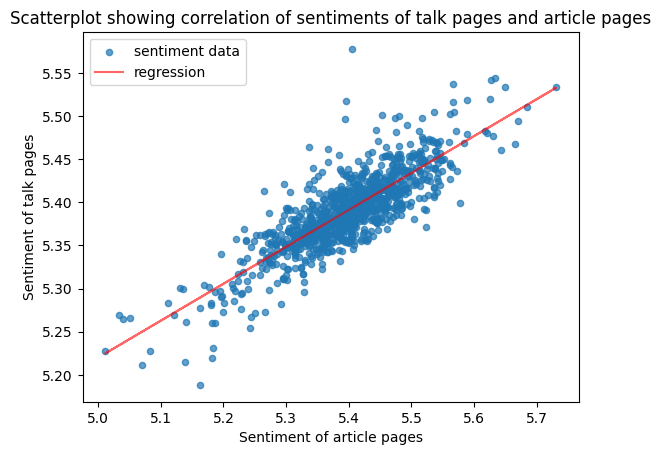

In [12]:
from sklearn.linear_model import LinearRegression

# create graph showing correlation value

fig, ax = plt.subplots()

sentiments_pages_df.plot.scatter (
    "articlepage_sentiment", "talkpage_sentiment", 
    title = "Scatterplot showing correlation of sentiments of talk pages and article pages", 
    xlabel = "Sentiment of article pages",
    ylabel = "Sentiment of talk pages",
    label='sentiment data',
    alpha=0.7,
    ax=ax
)

sentiments_pages_df = sentiments_pages_df.dropna()

X = sentiments_pages_df["articlepage_sentiment"].values.reshape(-1,1)
Y = sentiments_pages_df["talkpage_sentiment"].values.reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

ax.plot(X, Y_pred, color='red', alpha=0.6, label='regression')
ax.legend()

#### Interpretation of correlation results

The results give a correlation coefficient of 0.83. 
This means, the sentiments of article and talk pages are strongly positively correlated (anything over 0.5 on a scale from -1 to 1 is considered strongly correlated). 
Thus, if the sentiment of a article page is higher, the probability for the talk page to have a higher sentiment is high.

## Toxic comment extraction & analysis

First, we need to load the TF-IDF vectorizer that was trained in another notebook. For the interested reader, this notebook can found in our github repo. Link: <https://github.com/andste97/socialgraphs2023f-project/blob/main/project/nb-svm-strong-linear-baseline.ipynb>
The vectorizer will transform comments into TF-IDF-weighted sparse bag-of-words matrix. Sparse bag-of-word matrices are an efficient datastructe for inference with our model, TF-IDF is used to extract relevant features from the parsed comments.

In [12]:
df_comments = pd.DataFrame(list_for_df, columns = ['Author', 'Comment', 'Filename']) 

# load previously trained TF-IDF vectorizer
with open('./sentiment-models/vectorizer.pkl', 'rb') as file:
    vec = pickle.load(file)

# transform comments into TF-IDF-weighted sparse matrix
comments_sparse = vec.transform(df_comments['Comment'])

Next, we can run inference on the input data using the previously calculated and stored models, to obtain the toxic comments:

In [15]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((len(df_comments), len(label_cols)))

for i, j in enumerate(label_cols):
    print('predict', j)
    with open(f'./sentiment-models/{j}.pkl', 'rb') as file:
        m,r = pickle.load(file)
    preds[:,i] = m.predict_proba(comments_sparse.multiply(r))[:,1]
    df_comments[j] = preds[:,i]

# this created a matrix where each new column for label_cols contains the probability that a comment is in
# the category with the same title as the column name 

# get all authors that wrote toxic comments
# we chose a cutoff probability for defining a comment as toxic at 0.9
authors = []
for row in df_comments[df_comments["toxic"] > 0.9].iterrows():
    if row[1]["Author"]:
        authors.append(row[1]["Author"])


# how many toxic comments did we find?
print("number of toxic comments: ", len(df_comments[df_comments["toxic"] > 0.9]))

predict toxic
predict severe_toxic
predict obscene
predict threat
predict insult
predict identity_hate
number of toxic comments:  198


In [15]:
# Calculate how many authors wrote more than one toxic comment:

seen = set()
multiple_offenders = [x for x in authors if x in seen or seen.add(x)]    
print("number of people that have written more than one toxic comment: ", len(set(multiple_offenders)))

number of people that have written more than one toxic comment:  19


In [55]:
# first we need to consolidate pages and archives, so we work with all comments for a specific topic
df_comments_consolidated = df_comments.copy(deep=True)

df_comments_consolidated["Filename"] = df_comments_consolidated["Filename"].map(
    lambda x: x.split("/")[1].replace(".txt", "")
)

# Calculate number of toxic comments per consolidated talk page
count_toxic_per_page = df_comments_consolidated[df_comments_consolidated['toxic'] > 0.9] \
    .groupby('Filename').size() \
    .sort_values(ascending=False)

# Output top 10 pages with most toxic comments
print("top 10 pages with most toxic comments: ", count_toxic_per_page[:10])

top 10 pages with most toxic comments:  Filename
Talk:Anarchism          11
Talk:Adolf Hitler        9
Talk:Socialism           7
Talk:United States       7
Talk:Evolution           6
Talk:Michael Jackson     5
Talk:Abortion            4
Talk:Turkey              4
Talk:Israel              3
Talk:Jesus               3
dtype: int64


All in all, we saw a lot less toxic comments than we expected. We think, this can be attributed to the work of Wikipedia moderators, or potentially our algorithm did not find all toxic comments. Given the performance seen by evaluation the model on the test dataset (running inference on test data provided by Kaggl, then uploading our prediction and receiving the score), we think the former is more likely. However, to see if this is really the case, one would have to analyze the page history as well. This was infeasible given the time constraints of this exercise.

## Edit wars

inspired by R. Sumi, T. Yasseri, A. Rung, A. Kornai and J. Kertesz, "Edit Wars in Wikipedia," 2011 IEEE Third International Conference on Privacy, Security, Risk and Trust and 2011 IEEE Third International Conference on Social Computing, Boston, MA, 2011, pp. 724-727, doi: 10.1109/PASSAT/SocialCom.2011.47.

In [57]:
from collections import Counter

# Alternative but unreliable way of filtering reverts
#reverts = {k: [edit for edit in v if "comment" in edit and "revert" in edit["comment"].lower()] for k, v in infos["revision_dict"].items()}

def calc_edit_war_score_for_page_revisions(revision_list):
    if len(revision_list) > 2:
        usercounts = dict(Counter([revision["user"] for revision in revision_list if "user" in revision]))

        for i in range(len(revision_list) - 1):
            if "size" in revision_list[i] and "size" in revision_list[i+1]:
                revision_list[i]["diff"] = revision_list[i]["size"] - revision_list[i+1]["size"]
        revision_list[-1]["diff"] = 0

        m = 0
        for i in range(len(revision_list) - 1):
            if "diff" in revision_list[i] and "diff" in revision_list[i+1]:
                diffdiff = revision_list[i]["diff"] + revision_list[i+1]["diff"]
                # detect reverts
                if diffdiff == 0 and revision_list[i]["diff"] != 0:
                    if "user" in revision_list[i] and "user" in revision_list[i+1]:
                        user_orig = revision_list[i+1]["user"]
                        user_revert = revision_list[i]["user"]
                        m_score = min(usercounts[user_orig], usercounts[user_revert])
                        m += m_score
        
        # Normalize
        m /= len(revision_list)

        return m
    else:
        return -1

m_scores = {page_title: calc_edit_war_score_for_page_revisions(revision_list) for page_title, revision_list in infos["revision_dict"].items()}
m_scores = dict(sorted(m_scores.items(), key=lambda item: item[1], reverse=True))

print(m_scores)

{'Solar System': 13.403965303593557, 'Folk music': 11.865926748057714, 'Shen Kuo': 9.994255624700815, 'New York City': 9.157529109926978, 'Post-classical history': 8.528284244974287, 'Anarchism': 7.568471732764183, 'Poland': 7.414562458249833, 'Maya civilization': 6.507437588927694, 'Ecology': 5.518384093419599, 'United States': 4.314671301502914, 'Crusades': 4.307573869051983, 'The Beatles': 4.211602320464093, 'Sex': 4.050194083790657, 'India': 4.031541633509368, 'Abortion': 4.02913194188362, 'Jakarta': 3.9541873963515752, 'Liberalism': 3.5850806026762196, 'Jesus': 3.5094375176659023, 'Solar energy': 3.3741816693944355, 'Alcoholic beverage': 2.8843702192758798, 'Israel': 2.8698465855093453, 'Archaea': 2.8231753197893155, 'Algae': 2.77626073552081, 'Economics': 2.730169157497126, 'Biology': 2.670490236241977, 'Taiwan': 2.5634081060412948, 'British Empire': 2.4948901585257905, 'Chinese folk religion': 2.4839769926047657, 'United Kingdom': 2.392648753112573, 'Brazil': 2.386105399848501, 

Text(0.5, 0, 'n of toxic comments')

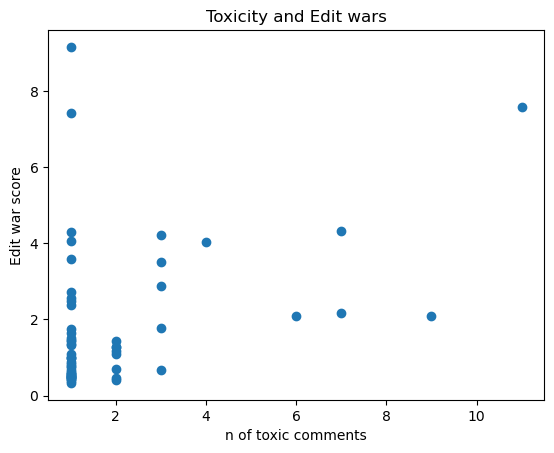

In [58]:
# Correlate

X = []
Y = []
for key, val in m_scores.items():
    if "Talk:" + key in count_toxic_per_page and val >= 0:
        X.append(count_toxic_per_page["Talk:" + key])
        Y.append(val)

fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.set_title("Toxicity and Edit wars")
ax.set_ylabel("Edit war score")
ax.set_xlabel("n of toxic comments")